In [1]:
import torch

import json
import urllib
from pytorchvideo.data.encoded_video import EncodedVideo

from torchvision.transforms import Compose, Lambda, TenCrop
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
    RandomCropVideo,
)
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample
)

/home/ados/anaconda3/envs/i3d/lib/python3.7/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The _functional_video module is deprecated. Please use the functional module instead.
  "The _functional_video module is deprecated. Please use the functional module instead."
/home/ados/anaconda3/envs/i3d/lib/python3.7/site-packages/torchvision/transforms/_transforms_video.py:26: UserWarning: The _transforms_video module is deprecated. Please use the transforms module instead.
  "The _transforms_video module is deprecated. Please use the transforms module instead."


In [3]:


torch.hub.list('facebookresearch/pytorchvideo:main','i3d')

Downloading: "https://github.com/facebookresearch/pytorchvideo/archive/main.zip" to /home/ados/.cache/torch/hub/main.zip


['c2d_r50',
 'csn_r101',
 'efficient_x3d_s',
 'efficient_x3d_xs',
 'i3d_r50',
 'mvit_base_16',
 'mvit_base_16x4',
 'mvit_base_32x3',
 'r2plus1d_r50',
 'slow_r50',
 'slow_r50_detection',
 'slowfast_16x8_r101_50_50',
 'slowfast_r101',
 'slowfast_r50',
 'slowfast_r50_detection',
 'x3d_l',
 'x3d_m',
 'x3d_s',
 'x3d_xs']

In [4]:
# model_name = 'i3d_r50'
model_name = 'x3d_m'
model = torch.hub.load('facebookresearch/pytorchvideo:main', model_name, pretrained=True)
model

Using cache found in /home/ados/.cache/torch/hub/facebookresearch_pytorchvideo_main


Net(
  (blocks): ModuleList(
    (0): ResNetBasicStem(
      (conv): Conv2plus1d(
        (conv_t): Conv3d(3, 24, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), bias=False)
        (conv_xy): Conv3d(24, 24, kernel_size=(5, 1, 1), stride=(1, 1, 1), padding=(2, 0, 0), groups=24, bias=False)
      )
      (norm): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (1): ResStage(
      (res_blocks): ModuleList(
        (0): ResBlock(
          (branch1_conv): Conv3d(24, 24, kernel_size=(1, 1, 1), stride=(1, 2, 2), bias=False)
          (branch2): BottleneckBlock(
            (conv_a): Conv3d(24, 54, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
            (norm_a): BatchNorm3d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act_a): ReLU()
            (conv_b): Conv3d(54, 54, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), groups=54, bias=False)
            (nor

In [5]:
# Set to GPU or CPU
device = "cuda:0"
model = model.eval()
model = model.to(device)

# remove classification layer
import torch.nn as nn
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

if model_name == 'x3d_m':
    model.blocks[5].proj = Identity()
    model.blocks[5].activation = Identity()
    # model.blocks[5].output_pool = Identity() # 이거 없어야됨. 왠진 몰?루
elif model_name == 'i3d_r50':
    model.blocks[6].proj = Identity()


In [6]:
json_url = "https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json"
json_filename = "kinetics_classnames.json"
try: urllib.URLopener().retrieve(json_url, json_filename)
except: urllib.request.urlretrieve(json_url, json_filename)

In [7]:
with open(json_filename, "r") as f:
    kinetics_classnames = json.load(f)

# Create an id to label name mapping
kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

In [8]:
kinetics_id_to_classname

{290: 'sharpening knives',
 115: 'eating ice cream',
 81: 'cutting nails',
 53: 'changing wheel',
 19: 'bench pressing',
 88: 'deadlifting',
 111: 'eating carrots',
 192: 'marching',
 358: 'throwing discus',
 231: 'playing flute',
 72: 'cooking on campfire',
 33: 'breading or breadcrumbing',
 218: 'playing badminton',
 276: 'ripping paper',
 244: 'playing saxophone',
 197: 'milking cow',
 169: 'juggling balls',
 130: 'flying kite',
 43: 'capoeira',
 187: 'making jewelry',
 100: 'drinking',
 228: 'playing cymbals',
 61: 'cleaning gutters',
 161: 'hurling (sport)',
 239: 'playing organ',
 361: 'tossing coin',
 395: 'wrestling',
 103: 'driving car',
 150: 'headbutting',
 147: 'gymnastics tumbling',
 186: 'making bed',
 0: 'abseiling',
 155: 'holding snake',
 278: 'rock climbing',
 71: 'cooking egg',
 182: 'long jump',
 17: 'bee keeping',
 365: 'trimming or shaving beard',
 63: 'cleaning shoes',
 86: 'dancing gangnam style',
 50: 'catching or throwing softball',
 164: 'ice skating',
 168: 

In [9]:
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]

# mean = [114.75, 114.75, 114.75]
# std = [57.375, 57.375, 57.375]

frames_per_second = 30
model_transform_params  = {
    "x3d_xs": {
        "side_size": 182,
        "crop_size": 182,
        "num_frames": 4,
        "sampling_rate": 12,
    },
    "x3d_s": {
        "side_size": 182,
        "crop_size": 182,
        "num_frames": 13,
        "sampling_rate": 6,
    },
    "x3d_m": {
        "side_size": 256,
        "crop_size": 224, #256 -> 224로 바꾸었음
        "num_frames": 16,
        "sampling_rate": 1,
    },
    "i3d_r50": {
        "side_size": 256,
        "crop_size": 224, #256 -> 224로 바꾸었음
        "num_frames": 16,
        "sampling_rate": 1,
    }
}

# Get transform parameters based on model
transform_params = model_transform_params[model_name]

# Note that this transform is specific to the slow_R50 model.
transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(transform_params["num_frames"]),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            # ShortSideScale(size=transform_params["side_size"]),
            # CenterCropVideo( -> RandomCrop으로 바꿈
            #     crop_size=(transform_params["crop_size"], transform_params["crop_size"])
            # )
            # RandomCropVideo(
            #     size=(transform_params["crop_size"], transform_params["crop_size"])
            # )
            # TenCrop(
            #     size=transform_params["crop_size"]
            # )
            
        ]
    ),
)

# The duration of the input clip is also specific to the model.
clip_duration = (transform_params["num_frames"] * transform_params["sampling_rate"])/frames_per_second

In [10]:
# url_link = "https://dl.fbaipublicfiles.com/pytorchvideo/projects/archery.mp4"
# video_path = 'archery.mp4'
import glob

video_paths = glob.glob('/home/workspaces/datasets/UCF_Crimes/videos/abnormal/*.mp4')
len(video_paths)
# video_path = 'Normal_Videos_003_x264.mp4'
# try: urllib.URLopener().retrieve(url_link, video_path)
# except: urllib.request.urlretrieve(url_link, video_path)

934

In [11]:
clip_duration, video_paths[0]

(0.5333333333333333,
 '/home/workspaces/datasets/UCF_Crimes/videos/normal/Normal_Videos173_x264.mp4')

In [12]:
import os
video_path = video_paths[0]
save_path = os.path.splitext(video_path.replace('videos', 'features_x3d'))[0] + '.npy'
save_path, os.path.dirname(save_path)

('/home/workspaces/datasets/UCF_Crimes/features_x3d/normal/Normal_Videos173_x264.npy',
 '/home/workspaces/datasets/UCF_Crimes/features_x3d/normal')

In [16]:
trans_video = transform(video_data)['video']

In [27]:
tencrop(trans_video)[0].shape
# trans_video.shape

torch.Size([3, 16, 224, 224])

In [36]:
import os
import numpy as np
from tqdm import tqdm
# Select the duration of the clip to load by specifying the start and end duration
# The start_sec should correspond to where the action occurs in the video

video_paths = glob.glob('/home/workspaces/datasets/UCF_Crimes/videos/normal/*.mp4')
tencrop = TenCrop((224,224))

batch_size = 8
num_crop = 10

# 308

for video_path in tqdm(video_paths[704:]):
    save_path = os.path.splitext(video_path.replace('videos', 'features_x3d'))[0] + '.npy'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Initialize an EncodedVideo helper class and load the video
    video = EncodedVideo.from_path(video_path)
    video_duration = float(video.duration)

    # video to features
    end_sec = 0
    features = []
    force_break = False
    while(end_sec < video_duration):
        if force_break: break
        
        inputs = []
        # load batch frames
        for idx in range(batch_size):
            if end_sec >= video_duration: break
        
            start_sec = end_sec
            end_sec = start_sec + clip_duration

            # Load the desired clip
            video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)
            
            if video_data['video'] is None: 
                force_break = True
                break
            
            trans_video = transform(video_data)['video']
            
            # for _ in range(num_crop):
                # Apply a transform to normalize the video input
                

                # Move the inputs to the desired device
            
            crops = tencrop(trans_video)
            
            for crop in crops:
                inputs.append(crop)
                
        if not force_break:
            inputs = torch.stack(inputs) # [batch_size*num_crop, 3, 16, 224, 224]
            # print(inputs.shape)

            # encode
            with torch.no_grad():
                feature = model(inputs.to(device)) # [batch_size*num_crop, 2048]        
                features.append(feature)

    features = torch.cat(features) # [?*batch_size*num_crop, 2048]
    # print(features.shape)
    features = torch.reshape(features, (-1, num_crop, 2048)) # [?, num_crop, 2048] == [B, D, F]
    # print(features.shape)

    features = features.cpu().numpy()
    np.save(save_path, features)

100%|██████████| 230/230 [1:58:55<00:00, 31.02s/it]   


In [34]:
start_sec

35.20000000000003

In [ ]:
import os
import numpy as np
from tqdm import tqdm
# Select the duration of the clip to load by specifying the start and end duration
# The start_sec should correspond to where the action occurs in the video

video_paths = glob.glob('/home/workspaces/datasets/UCF_Crimes/videos/abnormal/*.mp4')
tencrop = TenCrop((224,224))

batch_size = 8
num_crop = 10

for video_path in tqdm(video_paths[:]):
    save_path = os.path.splitext(video_path.replace('videos', 'features_x3d'))[0] + '.npy'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Initialize an EncodedVideo helper class and load the video
    video = EncodedVideo.from_path(video_path)
    video_duration = float(video.duration)

    # video to features
    end_sec = 0
    features = []
    force_break = False
    while(end_sec < video_duration):
        if force_break: break
        
        inputs = []
        # load batch frames
        for idx in range(batch_size):
            if end_sec >= video_duration: break
        
            start_sec = end_sec
            end_sec = start_sec + clip_duration

            # Load the desired clip
            video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)
            
            if video_data['video'] is None:
                print("force break:", video_path)
                force_break = True
                break
            
            trans_video = transform(video_data)['video']
            
            # for _ in range(num_crop):
                # Apply a transform to normalize the video input
                

                # Move the inputs to the desired device
            
            crops = tencrop(trans_video)
            
            for crop in crops:
                inputs.append(crop)
                
        if not force_break:
            inputs = torch.stack(inputs) # [batch_size*num_crop, 3, 16, 224, 224]
            # print(inputs.shape)

            # encode
            with torch.no_grad():
                feature = model(inputs.to(device)) # [batch_size*num_crop, 2048]        
                features.append(feature)

    features = torch.cat(features) # [?*batch_size*num_crop, 2048]
    # print(features.shape)
    features = torch.reshape(features, (-1, num_crop, 2048)) # [?, num_crop, 2048] == [B, D, F]
    # print(features.shape)

    features = features.cpu().numpy()
    np.save(save_path, features)

  1%|          | 5/950 [00:59<4:05:56, 15.61s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Explosion043_x264.mp4


  3%|▎         | 30/950 [05:56<3:13:47, 12.64s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Vandalism048_x264.mp4


  3%|▎         | 31/950 [06:23<4:17:00, 16.78s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/RoadAccidents095_x264.mp4


  5%|▍         | 43/950 [09:44<3:44:16, 14.84s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Explosion004_x264.mp4


  5%|▍         | 44/950 [10:01<3:53:04, 15.44s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Fighting014_x264.mp4


  5%|▍         | 45/950 [10:02<2:46:57, 11.07s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/RoadAccidents100_x264.mp4


  6%|▌         | 58/950 [13:21<2:23:18,  9.64s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/RoadAccidents125_x264.mp4


  7%|▋         | 63/950 [15:03<4:21:46, 17.71s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/RoadAccidents048_x264.mp4


  7%|▋         | 68/950 [15:48<2:35:33, 10.58s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Assault005_x264.mp4


  7%|▋         | 70/950 [16:08<2:40:34, 10.95s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/RoadAccidents142_x264.mp4


  8%|▊         | 76/950 [17:19<3:28:06, 14.29s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Burglary066_x264.mp4


  8%|▊         | 80/950 [18:32<3:30:02, 14.49s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Robbery138_x264.mp4


  9%|▉         | 85/950 [19:28<2:37:50, 10.95s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Explosion007_x264.mp4


  9%|▉         | 88/950 [20:44<4:02:54, 16.91s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Stealing083_x264.mp4


 10%|█         | 98/950 [22:32<2:41:56, 11.40s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/RoadAccidents078_x264.mp4


 11%|█         | 105/950 [24:33<3:20:55, 14.27s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Stealing101_x264.mp4


 12%|█▏        | 111/950 [25:54<2:47:32, 11.98s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Assault007_x264.mp4


 13%|█▎        | 121/950 [26:53<1:36:18,  6.97s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Fighting012_x264.mp4


 13%|█▎        | 124/950 [27:26<2:12:33,  9.63s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Shoplifting029_x264.mp4


 13%|█▎        | 125/950 [27:34<2:05:38,  9.14s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/RoadAccidents133_x264.mp4


 14%|█▎        | 129/950 [27:54<1:29:07,  6.51s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Abuse025_x264.mp4


 14%|█▎        | 130/950 [28:19<2:46:33, 12.19s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Shooting006_x264.mp4


 16%|█▌        | 149/950 [33:09<1:52:35,  8.43s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Explosion044_x264.mp4
force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Robbery120_x264.mp4


 16%|█▋        | 155/950 [34:00<1:48:44,  8.21s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Assault036_x264.mp4


 17%|█▋        | 157/950 [34:12<1:35:58,  7.26s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Burglary065_x264.mp4


 18%|█▊        | 173/950 [37:54<2:00:49,  9.33s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Stealing102_x264.mp4


 18%|█▊        | 174/950 [37:59<1:41:17,  7.83s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Stealing096_x264.mp4


 20%|██        | 192/950 [43:15<4:00:01, 19.00s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Burglary010_x264.mp4


 20%|██        | 193/950 [43:37<4:11:09, 19.91s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Shoplifting019_x264.mp4


 21%|██        | 200/950 [44:09<1:16:02,  6.08s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Shooting041_x264.mp4


 22%|██▏       | 211/950 [46:07<3:15:06, 15.84s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Assault010_x264.mp4


 23%|██▎       | 216/950 [48:11<3:52:20, 18.99s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Shooting046_x264.mp4


 24%|██▎       | 225/950 [50:24<2:27:17, 12.19s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Robbery069_x264.mp4


 24%|██▍       | 230/950 [51:08<1:33:05,  7.76s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Shoplifting054_x264.mp4


 51%|█████     | 484/950 [1:53:50<1:14:58,  9.65s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Explosion042_x264.mp4


 52%|█████▏    | 491/950 [1:56:28<2:07:27, 16.66s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Shoplifting025_x264.mp4


 52%|█████▏    | 494/950 [1:56:57<1:33:05, 12.25s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Assault018_x264.mp4


 53%|█████▎    | 499/950 [1:57:45<1:13:44,  9.81s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Vandalism009_x264.mp4


 53%|█████▎    | 502/950 [1:58:20<1:36:09, 12.88s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Burglary059_x264.mp4


 53%|█████▎    | 503/950 [1:58:22<1:10:42,  9.49s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Assault035_x264.mp4


 54%|█████▍    | 512/950 [2:01:43<3:28:40, 28.59s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Fighting051_x264.mp4


 55%|█████▌    | 524/950 [2:04:02<1:54:37, 16.14s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Robbery030_x264.mp4


 55%|█████▌    | 526/950 [2:04:19<1:23:57, 11.88s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/RoadAccidents016_x264.mp4


 56%|█████▌    | 532/950 [2:06:17<1:48:42, 15.60s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Burglary045_x264.mp4


 56%|█████▌    | 533/950 [2:06:55<2:36:10, 22.47s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Burglary085_x264.mp4


 57%|█████▋    | 539/950 [2:08:23<1:30:42, 13.24s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Arson023_x264.mp4


 57%|█████▋    | 545/950 [2:09:29<1:13:51, 10.94s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Fighting035_x264.mp4


 58%|█████▊    | 552/950 [2:10:44<1:02:35,  9.44s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Robbery113_x264.mp4


 58%|█████▊    | 555/950 [2:11:25<1:29:21, 13.57s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Arrest014_x264.mp4


 59%|█████▉    | 565/950 [2:14:42<1:09:23, 10.81s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Abuse023_x264.mp4


 60%|█████▉    | 569/950 [2:15:04<48:26,  7.63s/it]  

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Stealing019_x264.mp4


 61%|██████    | 576/950 [2:16:22<1:08:17, 10.95s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Shoplifting010_x264.mp4


 61%|██████    | 579/950 [2:16:47<57:13,  9.25s/it]  

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Arson039_x264.mp4


 62%|██████▏   | 587/950 [2:18:22<1:23:29, 13.80s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Burglary069_x264.mp4


 63%|██████▎   | 601/950 [2:21:14<1:11:00, 12.21s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Burglary020_x264.mp4


 64%|██████▎   | 605/950 [2:21:42<46:28,  8.08s/it]  

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Stealing030_x264.mp4


 64%|██████▍   | 607/950 [2:21:57<45:10,  7.90s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/RoadAccidents112_x264.mp4


 64%|██████▍   | 609/950 [2:23:29<2:57:00, 31.14s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Arrest012_x264.mp4


 65%|██████▍   | 614/950 [2:25:11<1:28:22, 15.78s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/RoadAccidents126_x264.mp4


 65%|██████▌   | 622/950 [2:26:44<46:51,  8.57s/it]  

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Arson038_x264.mp4


 66%|██████▌   | 623/950 [2:26:55<50:03,  9.19s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Robbery109_x264.mp4


 66%|██████▌   | 624/950 [2:27:17<1:10:34, 12.99s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Shooting012_x264.mp4


 66%|██████▌   | 626/950 [2:28:23<2:19:16, 25.79s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/RoadAccidents145_x264.mp4


 68%|██████▊   | 650/950 [2:34:06<56:02, 11.21s/it]  

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Assault050_x264.mp4


 69%|██████▊   | 651/950 [2:34:44<1:35:36, 19.18s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Fighting026_x264.mp4


 72%|███████▏  | 680/950 [2:42:05<1:29:28, 19.88s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Explosion021_x264.mp4


 72%|███████▏  | 682/950 [2:42:18<1:00:35, 13.57s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Robbery105_x264.mp4


 73%|███████▎  | 689/950 [2:44:03<54:55, 12.63s/it]  

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Shoplifting003_x264.mp4


 74%|███████▍  | 702/950 [2:46:32<53:10, 12.86s/it]  

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Fighting033_x264.mp4


 74%|███████▍  | 704/950 [2:46:46<41:47, 10.19s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Shooting019_x264.mp4


 75%|███████▌  | 716/950 [2:48:23<28:56,  7.42s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Shooting044_x264.mp4


 76%|███████▌  | 718/950 [2:48:52<43:50, 11.34s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Assault045_x264.mp4


 76%|███████▌  | 719/950 [2:48:56<35:03,  9.11s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Abuse018_x264.mp4


 77%|███████▋  | 728/950 [2:59:30<1:56:28, 31.48s/it]  

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Fighting024_x264.mp4


 77%|███████▋  | 730/950 [3:00:04<1:25:49, 23.41s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Burglary072_x264.mp4


 78%|███████▊  | 737/950 [3:00:51<29:53,  8.42s/it]  

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Stealing105_x264.mp4


 78%|███████▊  | 741/950 [3:01:38<38:45, 11.13s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Robbery007_x264.mp4


 79%|███████▊  | 746/950 [3:02:43<43:23, 12.76s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Vandalism028_x264.mp4


 79%|███████▉  | 749/950 [3:03:20<39:40, 11.85s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Arrest028_x264.mp4


 79%|███████▉  | 754/950 [3:03:55<22:07,  6.77s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/RoadAccidents070_x264.mp4


 80%|████████  | 760/950 [3:04:30<18:47,  5.94s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Fighting019_x264.mp4


 82%|████████▏ | 783/950 [3:09:27<28:05, 10.09s/it]  

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Robbery124_x264.mp4


 83%|████████▎ | 789/950 [3:11:22<57:06, 21.28s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Abuse002_x264.mp4


 84%|████████▍ | 796/950 [3:12:03<21:03,  8.21s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Robbery058_x264.mp4
force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Explosion023_x264.mp4


 84%|████████▍ | 801/950 [3:12:43<20:00,  8.06s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Shoplifting015_x264.mp4


 85%|████████▍ | 803/950 [3:13:03<21:37,  8.83s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Abuse020_x264.mp4


 85%|████████▍ | 804/950 [3:13:14<23:07,  9.50s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Assault012_x264.mp4


 86%|████████▌ | 816/950 [3:15:10<33:27, 14.98s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Assault008_x264.mp4


 86%|████████▌ | 818/950 [3:15:19<20:29,  9.32s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Assault029_x264.mp4


 87%|████████▋ | 825/950 [3:16:29<21:57, 10.54s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Fighting020_x264.mp4


 87%|████████▋ | 828/950 [3:17:10<27:32, 13.54s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Stealing069_x264.mp4


 87%|████████▋ | 829/950 [3:17:13<20:52, 10.35s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Assault009_x264.mp4


 89%|████████▊ | 842/950 [3:19:17<16:46,  9.32s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Vandalism030_x264.mp4


 89%|████████▉ | 845/950 [3:19:30<10:23,  5.94s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Abuse010_x264.mp4
force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Robbery080_x264.mp4


 89%|████████▉ | 846/950 [3:19:39<11:55,  6.88s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/RoadAccidents093_x264.mp4


 90%|████████▉ | 851/950 [3:20:38<16:48, 10.19s/it]

force break: /home/workspaces/datasets/UCF_Crimes/videos/abnormal/Stealing071_x264.mp4


 90%|█████████ | 855/950 [3:22:55<50:07, 31.66s/it]

drawing


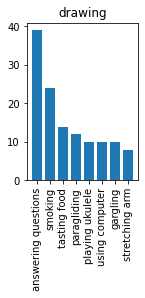

drinking


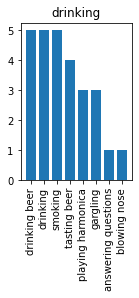

capture


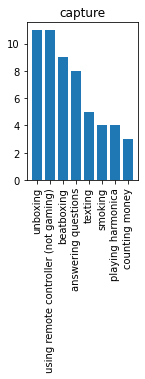

googling


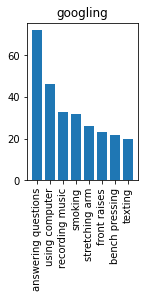

toilet


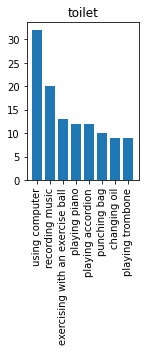

writing


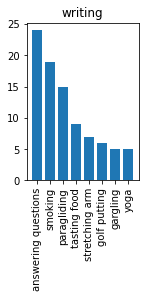

normal


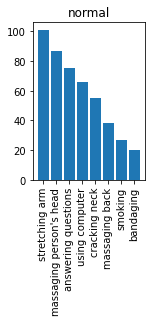

In [144]:
video_paths = glob.glob('acts/*.mp4')
# video_path = 'drawing.mp4'

cnt_dicts = []
for video_path in video_paths:
    video = EncodedVideo.from_path(video_path)
    video_duration = float(video.duration)

    cnt_dict = {}
    try:
        for start_sec in range(2, int(video_duration)-2):

            # start_sec += end_sec
            end_sec = start_sec + clip_duration

            # Load the desired clip
            video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)
            cropped_video = transform(video_data)

            preds = model(cropped_video['video'].unsqueeze(0).to(device))

            # Get the predicted classes
            post_act = torch.nn.Softmax(dim=1)
            preds = post_act(preds)
            pred_classes = preds.topk(k=5).indices[0]

            # Map the predicted classes to the label names
            pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes]
            # print("Top 5 predicted labels: %s" % ", ".join(pred_class_names))
            # print(video_path, start_sec, end_sec)


            for name in pred_class_names:
                if name in cnt_dict:
                    cnt_dict[name] += 1
                else:
                    cnt_dict[name] = 1
                    
        items = sorted(cnt_dict.items(), key=lambda x: x[1], reverse=True)

        items = items[:8]

        keys = []
        values = []
        for key, value in items:
            keys.append(key)
            values.append(value)

        print(video_path.split('/')[-1][:-4])

        import matplotlib.pyplot as plt
        import numpy as np

        x = np.arange(len(keys))
        # years = ['2018', '2019', '2020']
        # values = [100, 400, 900]

        plt.figure(figsize=(int(len(keys)/3),3))

        plt.bar(x, values, width=0.8, align='center')
        plt.xticks(x, keys, rotation=90)

        # plt.show()
        # plt.tight_layout()
        plt.title(video_path.split('/')[-1][:-4])
        plt.gcf().subplots_adjust(bottom=0.15)
        plt.savefig('plt_images/' + video_path.split('/')[-1][:-4] + '.png', bbox_inches = "tight")
        plt.show()            
        
        cnt_dicts.append(cnt_dict)
    except:
        print("video is too short")

normal


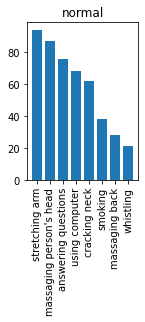

In [142]:
for idx, cnt_dict in enumerate(cnt_dicts):
    
    items = sorted(cnt_dict.items(), key=lambda x: x[1], reverse=True)

    items = items[:8]
    
    keys = []
    values = []
    for key, value in items:
        keys.append(key)
        values.append(value)

    print(video_paths[idx].split('/')[-1][:-4])

    import matplotlib.pyplot as plt
    import numpy as np

    x = np.arange(len(keys))
    # years = ['2018', '2019', '2020']
    # values = [100, 400, 900]

    plt.figure(figsize=(int(len(keys)/3),3))

    plt.bar(x, values, width=0.8, align='center')
    plt.xticks(x, keys, rotation=90)

    # plt.show()
    # plt.tight_layout()
    plt.title(video_paths[idx].split('/')[-1][:-4])
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.savefig('plt_images/' + video_paths[idx].split('/')[-1][:-4] + '.png', bbox_inches = "tight")
    plt.show()